In [1]:
# Install necessary libraries
!pip install yfinance ccxt pandas numpy matplotlib tensorflow pandas_ta

In [2]:
# Import libraries
import yfinance as yf
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
# Function to fetch stock data using yfinance
def fetch_stock_data(ticker, start_date='2010-01-01', end_date=None):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].reset_index()
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    return df

# Function to fetch cryptocurrency data using ccxt
def fetch_crypto_data(symbol='BTC/USD', exchange_name='kraken', timeframe='1d', limit=1000):
    exchange_class = getattr(ccxt, exchange_name)
    exchange = exchange_class()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    return data

# Fetch data for stocks
apple_data = fetch_stock_data('AAPL', start_date='2020-01-01')
tesla_data = fetch_stock_data('TSLA', start_date='2020-01-01')

# Fetch data for cryptocurrencies
btc_data = fetch_crypto_data('BTC/USD')
eth_data = fetch_crypto_data('ETH/USD')

# Display data
print("Apple Stock Data:\n", apple_data.head())
print("Tesla Stock Data:\n", tesla_data.head())
print("Bitcoin Crypto Data:\n", btc_data.head())
print("Ethereum Crypto Data:\n", eth_data.head())


Apple Stock Data:
                   timestamp       open       high        low      close  \
0 2020-01-02 00:00:00-05:00  71.799866  72.856606  71.545380  72.796013   
1 2020-01-03 00:00:00-05:00  72.020416  72.851746  71.862877  72.088280   
2 2020-01-06 00:00:00-05:00  71.206085  72.701508  70.954017  72.662727   
3 2020-01-07 00:00:00-05:00  72.672409  72.929322  72.100418  72.320976   
4 2020-01-08 00:00:00-05:00  72.022858  73.787315  72.022858  73.484352   

      volume  
0  135480400  
1  146322800  
2  118387200  
3  108872000  
4  132079200  
Tesla Stock Data:
                   timestamp       open       high        low      close  \
0 2020-01-02 00:00:00-05:00  28.299999  28.713333  28.114000  28.684000   
1 2020-01-03 00:00:00-05:00  29.366667  30.266666  29.128000  29.534000   
2 2020-01-06 00:00:00-05:00  29.364668  30.104000  29.333332  30.102667   
3 2020-01-07 00:00:00-05:00  30.760000  31.441999  30.224001  31.270666   
4 2020-01-08 00:00:00-05:00  31.580000  33.232

In [4]:
# Function to preprocess data for LSTM
def preprocess_data(df, feature_col='close', window_size=60):
    # Select the feature to predict (e.g., 'close' price)
    data = df[[feature_col]].values

    # Scale the data to the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create the training dataset
    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])

    # Convert to NumPy arrays and reshape
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM expects 3D input

    return X, y, scaler

# Preprocess data for all assets
window_size = 60
X_apple, y_apple, apple_scaler = preprocess_data(apple_data, window_size=window_size)
X_tesla, y_tesla, tesla_scaler = preprocess_data(tesla_data, window_size=window_size)
X_btc, y_btc, btc_scaler = preprocess_data(btc_data, window_size=window_size)
X_eth, y_eth, eth_scaler = preprocess_data(eth_data, window_size=window_size)

# Display shapes of data
print("Apple Data Shape:", X_apple.shape)
print("Tesla Data Shape:", X_tesla.shape)
print("Bitcoin Data Shape:", X_btc.shape)
print("Ethereum Data Shape:", X_eth.shape)


Apple Data Shape: (1191, 60, 1)
Tesla Data Shape: (1191, 60, 1)
Bitcoin Data Shape: (660, 60, 1)
Ethereum Data Shape: (660, 60, 1)


In [5]:
# Function to build an LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer to predict the closing price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build LSTM models
apple_model = build_lstm_model((X_apple.shape[1], 1))
tesla_model = build_lstm_model((X_tesla.shape[1], 1))
btc_model = build_lstm_model((X_btc.shape[1], 1))
eth_model = build_lstm_model((X_eth.shape[1], 1))

# Train LSTM models
apple_model.fit(X_apple, y_apple, epochs=20, batch_size=32)
tesla_model.fit(X_tesla, y_tesla, epochs=20, batch_size=32)
btc_model.fit(X_btc, y_btc, epochs=20, batch_size=32)
eth_model.fit(X_eth, y_eth, epochs=20, batch_size=32)


Epoch 1/20
38/38 [==============================] - 5s 33ms/step - loss: 0.0347
Epoch 2/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0050
Epoch 3/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0038
Epoch 4/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0037
Epoch 5/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0033
Epoch 6/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0031
Epoch 7/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0030
Epoch 8/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0031
Epoch 9/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0028
Epoch 10/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0027
Epoch 11/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0026
Epoch 12/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0032
Epoch 13/20
38/38 [==================

38/38 [==============================] - 1s 12ms/step


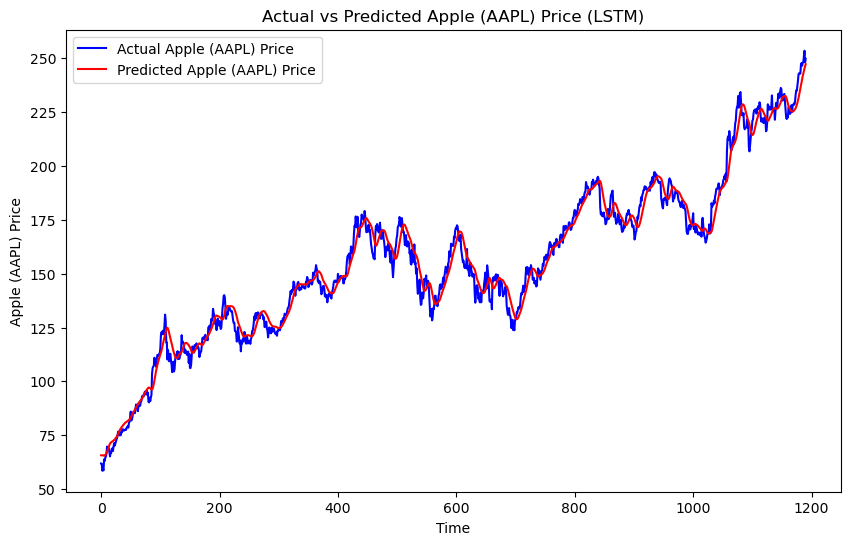

38/38 [==============================] - 1s 12ms/step


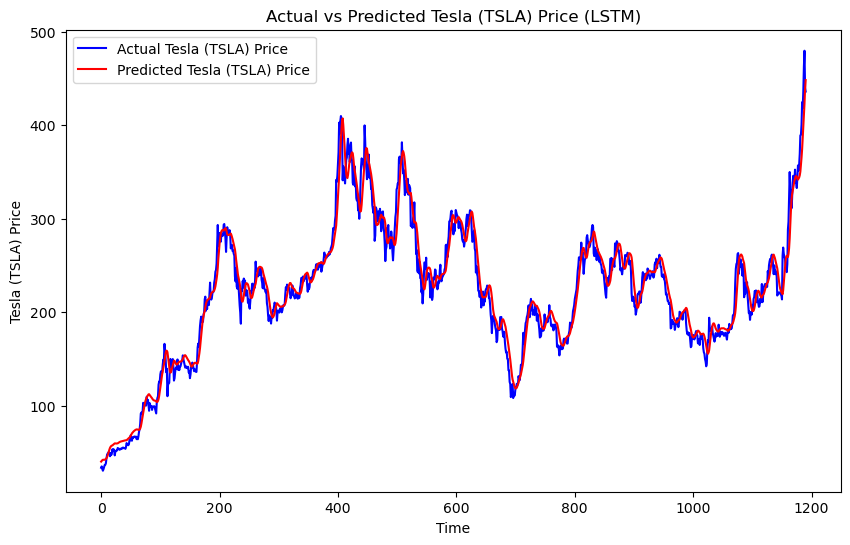

21/21 [==============================] - 1s 12ms/step


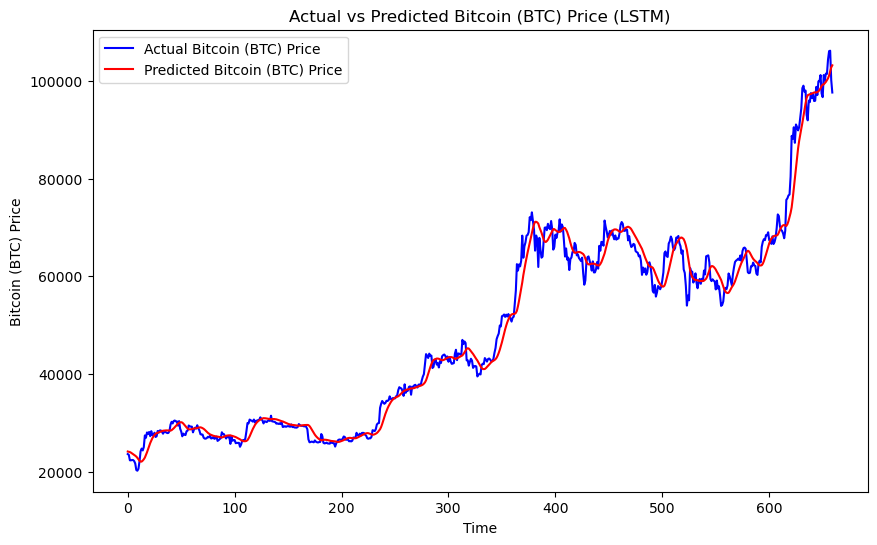

21/21 [==============================] - 1s 12ms/step


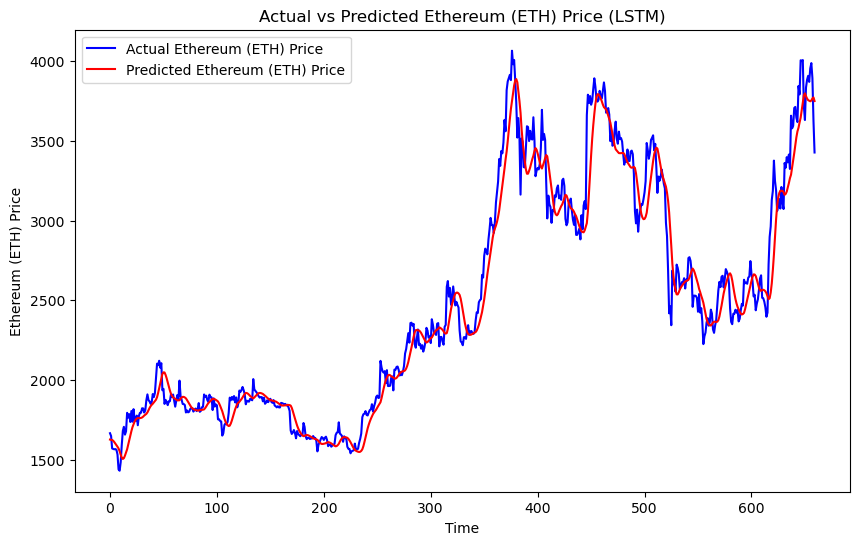

In [6]:
# Function to predict and visualize results
def evaluate_stock_model(model, X_data, y_data, scaler, stock_name="Stock"):
    # Predicting the prices
    predicted_prices = model.predict(X_data)

    # Rescale the predicted prices back to the original scale
    predicted_prices = scaler.inverse_transform(predicted_prices)
    actual_prices = scaler.inverse_transform(y_data.reshape(-1, 1))

    # Plot the actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices, color='blue', label=f"Actual {stock_name} Price")
    plt.plot(predicted_prices, color='red', label=f"Predicted {stock_name} Price")
    plt.title(f"Actual vs Predicted {stock_name} Price (LSTM)")
    plt.xlabel("Time")
    plt.ylabel(f"{stock_name} Price")
    plt.legend()
    plt.show()

# Evaluate models
evaluate_stock_model(apple_model, X_apple, y_apple, apple_scaler, stock_name="Apple (AAPL)")
evaluate_stock_model(tesla_model, X_tesla, y_tesla, tesla_scaler, stock_name="Tesla (TSLA)")
evaluate_stock_model(btc_model, X_btc, y_btc, btc_scaler, stock_name="Bitcoin (BTC)")
evaluate_stock_model(eth_model, X_eth, y_eth, eth_scaler, stock_name="Ethereum (ETH)")
